In [1]:
import numpy as np
import matplotlib.pyplot as pl
import tensorflow as tf
import matplotlib.pyplot as plt
# import WUT as WUT


In [2]:
import numpy as np
import tensorflow as tf
import types
from tensorflow.python.keras.layers.ops import core as core_ops
import mdn
from tensorflow.compat.v1.keras import layers
from tensorflow.python.keras import activations
from tensorflow_probability import distributions as tfd
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras import activations, initializers
import tensorflow_probability as tfp
tfd = tfp.distributions
import threading

class ThreadWithResult(threading.Thread):
    def __init__(self, group=None, target=None, name=None, args=(), kwargs={}, *, daemon=None):
        def function():
            self.result = target(*args, **kwargs)
        super().__init__(group=group, target=function, name=name, daemon=daemon)


class Dropout():


    def __init__(self, Model, rate, dropout_layers = [tf.keras.layers.Dense]):


        """Dropout Initializer. Turns a neural network into an droput network.

        Args:
            Model: Input Keras Model.
            rate: What rate to these neurons drop out
            dropout_layers: Types of layers to apply dropout to. Defaults are safe, add to this at your own risk.

        Returns:
            Nothing lol

        """

        self.model = Model()

        def adddropout(denselayer):
            def func(self, inputs, **kwargs):
                x = core_ops.dense(inputs, self.kernel, self.bias, self.activation, dtype=self._compute_dtype_object)
                return tf.nn.dropout(x, noise_shape=None, rate=rate)
            return func

        for layer in self.model.layers[:-1]:
            if layer.__class__ in dropout_layers:
                func = adddropout(layer)
                layer.call = types.MethodType(func, layer)

    def compile(self, *args, **kwargs):

        """compile. Literally use this as you'd use the normal compile.

        Returns:
            Nothing lol

        """

        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):

        """fit. Literally use this as you'd use the normal keras fit.

        Returns:
            Nothing lol.

        """


        self.model.fit(*args, **kwargs)

    def evaluate(self, *args, trials = 3, **kwargs):


        """evaluate. Literally use this as you'd use the normal keras evaluate.
        Args:
            trials: how many times to run the MCDropout network to get empirical variance. I would recommend higher than 3.

        Returns:
            The model's score, evaluated on whatever inputs you just fed it.

        """


        threads = []
        results = []


        for _ in range(trials):
            threads.append(ThreadWithResult(target=self.model.evaluate, args=args, kwargs=kwargs))
            threads[-1].start()

        for thread in threads:
            thread.join()
            results.append(thread.result)

        if type(results[0]) is tuple:
            return list(zip(*results))
        return results

    def predict(self, *args, trials = 15, return_std = True, **kwargs):

        """predict. Literally use this as you'd use the normal keras predict.
        Args:
            trials: how many times to run the network
            return_std: checks if you would even like the std.

        Returns:
            a mean and variance, for each input.

        """

        threads = []
        predictions = []

        for _ in range(trials):
            threads.append(ThreadWithResult(target=self.model.predict, args=args, kwargs=kwargs))
            threads[-1].start()


        for thread in threads:
            thread.join()
            predictions.append(thread.result)

        predictions = tf.stack(predictions)
        mean_preds = tf.reduce_mean(predictions, axis = 0)

        if not return_std:
            return mean_preds

        std_preds = tf.math.reduce_std(predictions, axis = 0)
        mean_preds = tf.expand_dims(mean_preds, 1)

        std_preds = tf.expand_dims(std_preds, 1)


        return tf.concat([mean_preds, std_preds], axis = 1)


    def sample(self, *args, trials = 3, **kwargs):
        """evaluate. Literally use this as you'd use the normal evaluate.

        Args:
            return_std: Defaults to true, just checking if you actually want the std.

        Returns:
            Output of each network for each input (Number of ensembels x Number of test inputs x Number of outputs)

        """

        threads = []
        predictions = []

        for _ in range(trials):
            threads.append(ThreadWithResult(target=self.model.predict, args=args, kwargs=kwargs))
            threads[-1].start()


        for thread in threads:
            thread.join()
            predictions.append(thread.result)
        predictions = tf.stack(predictions)

        return predictions


In [3]:
def plot1d_meanvar(X, Y, Xq, Yq, sigma=None, ylims=[-1.5, 1.5]):
    pl.figure()
    pl.scatter(X, Y, c = 'k', s = 1, label = 'data')
    if Yq is not None:
        pl.plot(Xq, Yq, c = 'b', label = 'predicted mean')
    if sigma is not None:
        pl.fill_between(Xq.squeeze(), tf.squeeze(Yq - 2*sigma), tf.squeeze(Yq + 2*sigma), alpha = 0.2, label = 'predicted SD')
        pl.ylim(ylims)
    pl.legend()
    
def plot1d_samples(X, Y, Xq, Ys, ylims=[-1.5, 1.5]):
    pl.figure()
    pl.scatter(X, Y, c = 'k', s = 1, label = 'data')
    for i in range(Yreg1s.shape[0]):
        pl.plot(Xq, Ys[i,:,:], c = 'b', alpha = 0.3, label = 'prediction {}'.format(i))
    pl.ylim(ylims)
    pl.legend()

X query/predict shapes: (10000, 1)
X-Y train shapes: (10000, 1) (10000, 1)
X-Y test shapes: (10000, 1) (10000, 1)


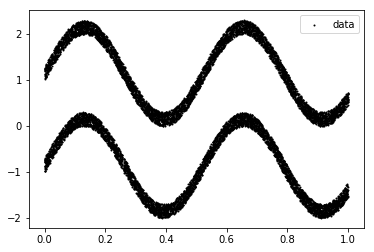

In [4]:
# ## Noise Function

# bimix_gauss = tfd.Mixture(
# cat=tfd.Categorical(probs=[mix, 1.-mix]),
# components=[
#   tfd.Normal(loc=-5., scale=0.1),
#   tfd.Normal(loc=+1., scale=0.5),
# ])

# Groundtruth function
def groundtruth1(X, noise=0):
    return np.sin(12*X) + noise*np.random.random((len(X),1)) - 1 + (2*np.random.randint(0,2, X.shape))

# Query dataset for prediction
Nq = 10000
Xtest = np.linspace(-0.2, 1.2, Nq)[:,None]
Ytest = groundtruth1(Xtest)
print("X query/predict shapes:", Xtest.shape)

# Training dataset
N = 10000
Xtrain = np.random.random((N,1))
Ytrain = groundtruth1(Xtrain, noise=.3)

# Calibration dataset
Xcal = np.random.random((N,1))
Ycal = groundtruth1(Xcal, noise=.3)

# Noisy Testing dataset
Xntest = np.random.random((N,1))
Yntest = groundtruth1(Xntest, noise=.3)


print("X-Y train shapes:", Xtrain.shape, Ytrain.shape)
ylims = [-1.5,1.5] # This will be used for plotting
plot1d_meanvar(Xtrain, Ytrain, None, None, None, ylims)


# Test dataset for evaluation
print("X-Y test shapes:", Xtest.shape, Ytest.shape)

In [5]:
class RegModel(tf.keras.Model):

    def __init__(self):
        super(RegModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(8, activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(64, activation = tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(64, activation = tf.nn.relu)
        self.dense4 = tf.keras.layers.Dense(1)

    def call(self, inputs, training = False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

In [6]:
# Train

# Model
rate = 0.2 # What rate to neurons drop out
mcmc  = Dropout(RegModel, rate = 0.2, dropout_layers = [tf.keras.layers.Dense])

# Train
mcmc.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=.004), loss = tf.keras.losses.MSE)
mcmc.fit(Xtrain, Ytrain, epochs = 10, batch_size = 200)


Epoch 1/10
50/50 [==============================] - 1s 1ms/step - loss: 1.5546
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5372
Epoch 3/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5399
Epoch 4/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5032
Epoch 5/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5196
Epoch 6/10
50/50 [==============================] - 0s 1ms/step - loss: 1.4807
Epoch 7/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5165
Epoch 8/10
50/50 [==============================] - 0s 1ms/step - loss: 1.5026
Epoch 9/10
50/50 [==============================] - 0s 1ms/step - loss: 1.4943
Epoch 10/10
50/50 [==============================] - 0s 1ms/step - loss: 1.4659


(10000, 2, 1)
tf.Tensor(0.014069909, shape=(), dtype=float32)
(10000, 1)


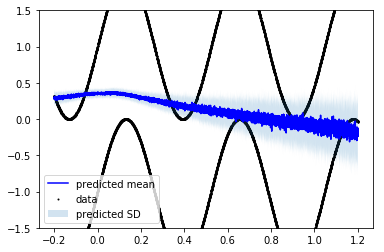

In [7]:
# Pre-Calibration Testing

Yptest = mcmc.predict(Xtest)
print(Yptest.shape)
Ymtest = Yptest[:,0]
Yvtest = Yptest[:,1]

print(tf.reduce_min(Yvtest))


print(Xtest.shape)
plot1d_meanvar(Xtest, Ytest, Xtest, Ymtest, Yvtest)





In [12]:
# Calibrator: CRUDE

class CRUDE():
    def __init__(self, model, xcal, ycal):
        yhat = model.predict(xcal)
        yhat_mean, yhat_std = yhat[:,0], yhat[:,1]
        true_error = yhat_mean - ycal
        scaled_true_error = true_error/yhat_std
        self.scaled_true_error = tf.sort(scaled_true_error, axis=0, direction='ASCENDING')
        self.len_cal = len(self.scaled_true_error)
        self.model = model
        
    def percentile(self, x, p):
        
        yhat = self.model.predict(x)
        yhat_mean, yhat_std = yhat[:,0], yhat[:,1]
        index = int(self.len_cal * p)
        error = self.scaled_true_error[index]
        scaled_error = yhat_std * error
        applied_error = yhat_mean + scaled_error
        
        return applied_error


In [13]:
# Function to calculate Calibration Curve
def Calibration_Curve(model, Xntest, Yntest, num_percentiles=100):
    intended_percentiles = []
    true_percentiles = []
    for percentile in range(num_percentiles):
        p = percentile/num_percentiles
        print(p)
        calculation = model.percentile(Xntest, p)
        ptrue = tf.reduce_sum(tf.cast(Yntest < calculation, tf.float32))/len(Yntest)
        intended_percentiles.append(p)
        true_percentiles.append(ptrue)
        
    return intended_percentiles, true_percentiles
    


In [14]:
# Calibration Curve for CRUDE
crude = CRUDE(mcmc, Xcal, Ycal)
ip, tp = Calibration_Curve(crude, Xntest, Yntest)
plt.scatter(ip, tp)

0.0
0.01


KeyboardInterrupt: 

In [15]:
# Calibrator: Kuleshov

class Kuleshov():
    def __init__(self, model, xcal, ycal, num_buckets=100):
        self.num_buckets = num_buckets
        self.model = model
        
        yhat = model.predict(xcal)
        yhat_mean, yhat_std = yhat[:,0], yhat[:,1]
        percentiles = self.extract_percentiles(yhat_mean, yhat_std, ycal)
        self.bucket_indices = self.create_buckets(percentiles)
        
    def percentile(self, x, p):
        approx_index = int(p*(len(self.bucket_indices)))
        norm_percentile = self.bucket_indices[approx_index]
        yhat = self.model.predict(x)
        yhat_mean, yhat_std = yhat[:,0], yhat[:,1]
        dist = tfd.Normal(loc=yhat_mean, scale=yhat_std)
        return dist.quantile(norm_percentile)
             
    def extract_percentiles(self, mean, std, true):
        dist = tfd.Normal(loc=mean, scale=std)
        return dist.cdf(true)
    
    def create_buckets(self, percentiles):
        percentiles = tf.sort(percentiles, axis=0, direction='ASCENDING')
        percentiles = [0.0] + [percentiles[i * int(len(percentiles)/(self.num_buckets-1))] for i in range(self.num_buckets-1)] + [1.0]
        return percentiles
    


In [ ]:
# Calibration Curve for Kuleshov


kul = Kuleshov(mcmc, Xcal, Ycal)
ip, tp = Calibration_Curve(kul, Xntest, Yntest)
plt.scatter(ip, tp)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93


In [ ]:
# Calibration Curve for Kuleshov


kul = Kuleshov(mcmc, Xcal, Ycal)
ip, tp = Calibration_Curve(kul, Xntest, Yntest)
plt.scatter(ip, tp)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29


In [18]:
crude_demo = CRUDE(regmodel1dp, Xcal1, Ycal1)

In [126]:
crude_demo = CRUDE(regmodel1dp, Xcal1, Ycal1)

In [19]:
print(crude_demo.scaled_true_error[int(len(crude_demo.scaled_true_error) * .5)])

tf.Tensor([-0.02218159], shape=(1,), dtype=float32)


In [20]:
Xtest = np.random.random((N,1))
Ytest = groundtruth1(Xcal1) + 0.05*np.random.random((N,1))

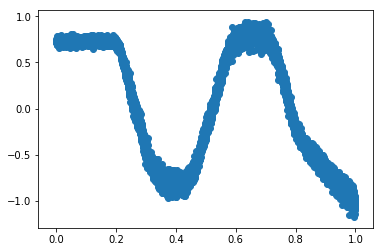

In [21]:
Yhat_test = regmodel1dp.predict(Xtest)
Yhat_test_mean = Yhat_test[:,0]

plt.scatter(Xtest, Yhat_test_mean)

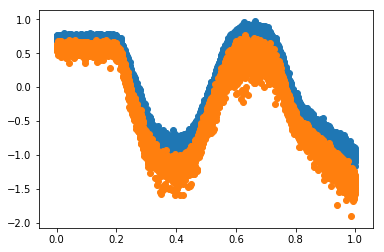

In [22]:
Yhat = crude_demo.percentile(Xtest, .5)
Yhat1 = crude_demo.percentile(Xtest, .1)

# sd = Yhat[:,1]
# mean = Yhat[:,0]
plt.scatter(Xtest, Yhat)
plt.scatter(Xtest, Yhat1)

In [ ]:
pl.scatter(Xtest, Ytest, c = 'k', s = 1, label = 'data')
pl.plot(Xreg1q, Yhat[:,0], c = 'b', label = 'predicted mean')
pl.fill_between(Xreg1q.squeeze(), mean - sd, mean + sd, alpha = 0.2, label = 'predicted SD')
pl.ylim([-1.5, 1.5])
pl.legend()